In [1]:
#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

import GPy
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score

# Some hyperparameters

In [2]:
ndim = 2
total_n = 100
start_n = 10
end_n = 60
test_size = 40

var = 100
lengthscale = 0.11

k = GPy.kern.RBF(ndim, variance=var, lengthscale=lengthscale)
lik = GPy.likelihoods.Bernoulli()

# Creating dataset

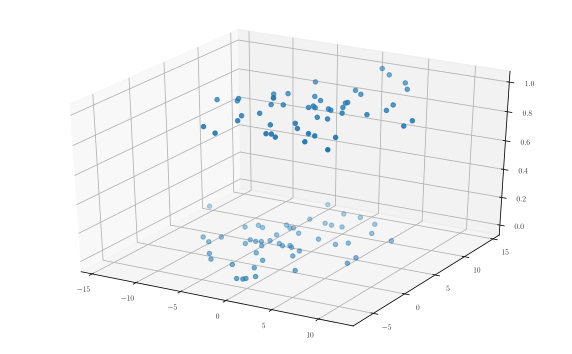

In [3]:
import GetData

Data = GetData.Generated2dimData(total_n, start_n, end_n, test_size)

U, X_train, y_U, y_train, X_test, y_test = Data.generate_data()

# An example Inference
To see whether gaussian process learns on the data

In [ ]:
m = GPy.core.GP(X=X_train,
                Y=y_train.reshape(-1, 1), 
                kernel=k, 
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik)

# m.plot(plot_density = True)

# Preparation for actually experiments

In [ ]:
#create structure of folders to store plots for different score_functions
!rm -r score_plots
!mkdir score_plots

!mkdir ./score_plots/rand
!mkdir ./score_plots/vari
!mkdir ./score_plots/sqsm
!mkdir ./score_plots/RKHS
!mkdir ./score_plots/Hvar
!mkdir ./score_plots/l2fm

# Active learning part

In [ ]:
import ScoreFunctions
import Utils

# The main loop
Train 6 gps with different score function

In [ ]:
acc_rand = []
acc_vari = []
acc_sqsm = []
acc_RKHS = []
acc_Hvar = []
acc_l2fm = []

models = []

X_train_0   = X_train
y_train_0   = y_train
U_0         = U
y_U_0       = y_U
 
for score, acc in (zip((ScoreFunctions.calculate_scores_rand, ScoreFunctions.calculate_scores_vari, 
                            ScoreFunctions.calculate_scores_Hvar, ScoreFunctions.calculate_scores_RKHS, 
                            ScoreFunctions.calculate_scores_l2fm, ScoreFunctions.calculate_scores_sqsm),
                            (acc_rand, acc_vari, acc_Hvar, acc_RKHS, acc_l2fm, acc_sqsm))):
    X_train = X_train_0
    y_train = y_train_0
    U = U_0
    y_U = y_U_0
    
    k = GPy.kern.RBF(ndim, variance=var, lengthscale=lengthscale)
    m = GPy.core.GP(X=X_train,
                    Y=y_train.reshape(-1, 1), 
                    kernel=k, 
                    inference_method=GPy.inference.latent_function_inference.Laplace(),
                    likelihood=lik)
    
    K = Utils.get_K(m, X_train)
    inv_K = Utils.get_inv_K(m, X_train)
    
    for i in tqdm(range(start_n, end_n)):
        #0. learn GP on the data
        m = GPy.core.GP(X=X_train,
                        Y=y_train.reshape(-1, 1), 
                        kernel=m.kern, 
                        inference_method=GPy.inference.latent_function_inference.Laplace(),
                        likelihood=lik)
        
        #1. calculate score at each point of the rest dataset in U and y_u, get the ind of maximum
        scores = score(np.array(U), m, X_train, y_train, inv_K)
        ind = np.argmax(scores)

        #2. append new point to the training dataset and remove it from U
        X_train = np.concatenate((X_train, U[ind].reshape(-1, ndim)), axis = 0)
        y_train = np.append(y_train, y_U[ind]).reshape(-1, 1)
        
        a = m.kern.K(U[ind].reshape(-1, ndim), X_train[:X_train.shape[0]-1]).T
        
        inv_K = Utils.update_inv_K(m, X_train, inv_K, U[ind], a)
        
        #placing this function call right here is important
        #since draw_score should see whole U included the point to be deleted
        Data.draw_score(m, U, "./score_plots/"+str(score)[27:31]+"/", i, X_train, score, y_train, inv_K)

        U = np.delete(U, ind, axis = 0)
        y_U = np.delete(y_U, ind)

        #3. count accuracy and log_loss
#         acc.append(accuracy_score(y_test, Utils.to_labels(m.predict(X_test.reshape(-1, ndim))[:][0])))
    
    #after the gp is learned save it to models
    models.append(m)
    np.savetxt("acc_" + str(score)[27:31] + ".txt", acc)

 /home/dahakot/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /home/dahakot/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [ ]:
# for m in models:
#     m.plot()
#     plt.plot(X_train, y_train, 'b.')

In [ ]:
acc_rand = np.loadtxt("acc_rand.txt")
acc_vari = np.loadtxt("acc_vari.txt")
acc_sqsm = np.loadtxt("acc_sqsm.txt")
acc_RKHS = np.loadtxt("acc_RKHS.txt")
acc_Hvar = np.loadtxt("acc_Hvar.txt")
acc_l2fm = np.loadtxt("acc_l2fm.txt")

In [ ]:
import matplotlib;matplotlib.rcParams['figure.figsize'] = (16,10)

plt.plot(range(start_n, start_n + len(acc_rand)), acc_rand[:len(acc_rand)], label='rand')
plt.plot(range(start_n, start_n + len(acc_vari)), acc_vari[:len(acc_vari)], label='var')
plt.plot(range(start_n, start_n + len(acc_sqsm)), acc_sqsm[:len(acc_sqsm)], label='L2')
plt.plot(range(start_n, start_n + len(acc_RKHS)), acc_RKHS[:len(acc_RKHS)], label='RKHS')
plt.plot(range(start_n, start_n + len(acc_Hvar)), acc_Hvar[:len(acc_Hvar)], label='Hvar')
plt.plot(range(start_n, start_n + len(acc_l2fm)), acc_l2fm[:len(acc_l2fm)], label='l2fm')

plt.title("accuracy(n)")
plt.ylabel('$accuracy$')
plt.xlabel('$size of training dataset$')
plt.legend()
plt.savefig('accuracy2dim.png')